<h1 style = "font-size:3rem;color:orange">Pitch Estimation Comparison</h1>

Comparing two correlation methods (autocorrelation and comb-filtering) and harmonic summation

In [4]:
import numpy as np
import matplotlib.pyplot as plt  
import librosa                    
import librosa.display            

Import audio and plot in frequency domain

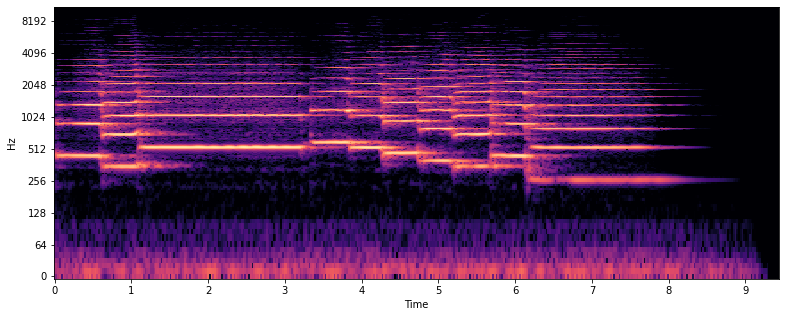

In [10]:
x , sr = librosa.load('../samples/trumpetFull.wav')
STFT = librosa.stft(x) # return two vectors: magnitude and phase
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
fig, ax = plt.subplots(figsize = (13, 5))
img = librosa.display.specshow(STFT_db,
                               y_axis='log',
                               x_axis='time', 
                               ax=ax)

<h1 style = "font-size:3rem;color:orange">Autocorrelation</h1>

The pitch, or fundamental period $\tau$ can be estimated using the autocorrelation function, which is based on the similarity between the original and shifted signal:

$r_x = \sum_{n=\tau}^{N-1}x[n] \cdot x[n+\tau]$

Then the pitch can be obtained by going trough a set of periods and minimizing the objective function: 

$\hat{\tau} = argmax \ r_x(\tau)$ 


Function for detection of pitch for segment of data:

In [2]:
def autocor(data, minFreq, maxFreq):    
    nData = len(data);
    minTau = int(max(1,np.ceil(1 / maxFreq)));        # Minimum period
    maxTau = int(min(nData,np.floor(1 / minFreq)));   # Maximum period
    nTau = int(maxTau - minTau);
    
    objectiveFunc = np.zeros(nTau);            # Objective funciton we want to minimize
    
    for tau in range(minTau,maxTau):
        xt = data[range(0,len(data)-1-tau)];               # Trimeed delayed input signal
        x = data[range(tau,len(data)-1)];                  # Trimmed input data
        
        autoCor = 0;
        
        for n in range(0,len(x)):
            autoCor = autoCor + (1/(nData-tau))*x[n]*xt[n]; # Using the autocorrelation function
        
        objectiveFunc[tau-minTau] = max(autoCor,0);         # Put the outcome into the objective function vec
    
    index = np.argmax(objectiveFunc);
    pitch = 1/(index+minTau);
    
    
    return pitch

<h1 style = "font-size:3rem;color:orange">Comb-filtering</h1>

Similar to autocorrelation, but more accurate as it also includes scalar $a$, that accounts for amplitude changes.
The difference, or error, between the signal and shifted signal is $e[n] = x[n] - ax[n-\tau]$

Then the objective function is obtained by squaring the error (finding the size) and going through a set of periods:

$J(a,\tau) = \sum_{n=\tau}^{N-1}e[n]^2$

Then the pitch can be obtained by minimizing the objective function: 

$\hat{\tau} = argmin \ J(a, \tau)$.

Finding $a$:

\begin{align}
     J(a,\tau) &= \sum_{n=\tau}^{N-1} |e(n)|^2 = \sum_{n=\tau}^{N-1} |x(n) - ax(n-\tau)|^2\\
               &=\sum_{n=\tau}^{N-1} x^2(n) + a^2\sum_{n=\tau}^{N-1}x^2(n-\tau) -2a\sum_{n=\tau}^{N-1}x(n)x(n-\tau) \\
      \frac{dJ}{da} &= 2a\sum_{n=\tau}^{N-1}x^2(n-\tau) -2\sum_{n=\tau}^{N-1}x(n)x(n-\tau).\\
      \frac{dJ}{da} &= 0 \Longrightarrow a = \frac{\sum_{n=\tau}^{N-1}x(n)x(n-\tau)}{\sum_{n=\tau}^{N-1}x^2(n-\tau)}.
\end{align}

Inserting $a$ into the objective function:

\begin{align}
   \hat{\tau} &= \operatorname*{argmin}_{\tau \in [\tau_{min}, \tau_{max}]} J(a,\tau)\\
    &= \operatorname*{argmin}_{\tau \in [\tau_{min}, \tau_{max}]} \left[ \sum_{n=\tau}^{N-1} x^2(n) -2 \frac{\sum_{n=\tau}^{N-1}x^2(n)x^2(n-\tau)}{\sum_{n=\tau}^{N-1}x^2(n-\tau)} + \frac{\sum_{n=\tau}^{N-1}x^2(n)x^4(n-\tau)}{\sum_{n=\tau}^{N-1}x^4(n-\tau)}\right]\\
    &= \operatorname*{argmin}_{\tau \in [\tau_{min}, \tau_{max}]} \left[ \sum_{n=\tau}^{N-1} x^2(n) - \frac{\left[\sum_{n=\tau}^{N-1}x(n)x(n-\tau)\right]^2}{\sum_{n=\tau}^{N-1}x^2(n-\tau)}\right].
\end{align}

<h1 style = "font-size:3rem;color:orange">Harmonic Summation</h1>

The pitch, or fundamental period $\tau$ can be estimated using the autocorrelation function, which is based on the similarity between the original and shifted signal:

$r_x = \sum_{n=0}^{N-1}x[n] \cdot x[n+\tau]$

Then the pitch can be obtained by going trough a set of periods and minimizing the objective function. 

<h1 style = "font-size:3rem;color:orange">Comparison</h1>

Break into segments and perform autocorrelation

In [6]:
min_freq = 100;                                        # Minimum frequency that can be estimated
max_freq = 1000;                                       # Maximum frequency that can be estimated
 
norm_min_freq = min_freq / sr;                         # Normalized min frequency            
norm_max_freq = max_freq / sr;                         # Normalized max frequency

overlap = 50;                                          # Percentage overlap from previous segment
nData = len(x);                                        # Total amount of samples
segmentLength =  100/1000;                              # Length of each segment in miliseconds
nSegmentLength = segmentLength * sr;                   # Segment Length in samples
iVector = list(range(1, int(nSegmentLength) + 1));     # Vector used for indexing

nShift = int(round((1-overlap/100)*nSegmentLength));        # Segment shift in samples
number_of_segments = int(np.ceil((nData-nSegmentLength+1)/nShift));  # Total amount of segments                                   

pitchVec = np.zeros(nData);                             # Vector containing the estimated pitch using Auto Correlation

for i in range(0,int(number_of_segments)):
    pitchVec[iVector] =  autocor(x[iVector], norm_min_freq, norm_max_freq);              # Estimate pitch using Auto Correlation
    iVector = [z+nShift for z in iVector];
    #print(f'Processing section {i+1} of {number_of_segments}');
    

Plot the estimated pitch and compare to STFT

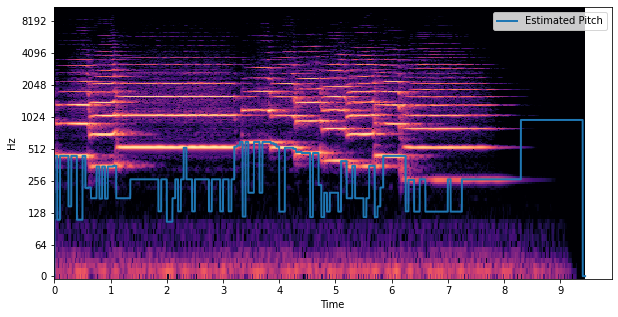

In [7]:
STFT = librosa.stft(x) # return two vectors: magnitude and phase
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
fig, ax = plt.subplots(figsize = (10, 5))
img = librosa.display.specshow(STFT_db,
                               y_axis='log',
                               x_axis='time', 
                               ax=ax)

pitch_norm = pitchVec * sr
timeVec = np.arange(0, nData/sr, 1/sr, dtype=np.float64)

plt.plot(timeVec, pitch_norm, lw=2, label = 'Estimated Pitch')
plt.legend()
plt.show()